Code ran under dev branch of Pyro and master branch of Pytorch  
Pytorch: 67bbf5  
Pyro: 7cb4c6  

### Personal observation:
I think the pyro API is relatively easy to understand, and the devs team make an effort to separete the model and the inference.   
As using sampling to do inference goes, a sampler (called kernel) takes a model and internally setup the logp and dlogp, as well as the MH kernel for proposal.   
One awkward thing of pyro is that, when a distribution is wrapped into a torch Variable using `pyro.sample`, it's default value is taken from the memory instead of the default of the distribution. It cause slow convergence a lot of times.  
To make the comparison more direct, all optimuization and tuning in pymc3 is turned off.  

In [1]:
%pylab inline
from tqdm import tqdm, trange
from collections import defaultdict, namedtuple
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
from torch.autograd import Variable

import pyro
import pyro.distributions as dist
from pyro.infer.mcmc.hmc import HMC
from pyro.infer.mcmc.nuts import NUTS
from pyro.infer.mcmc.mcmc import MCMC

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
pyro.__version__

'0.2.0-a0+7cb4c63'

# High-D Gaussian

In [3]:
ndim, num_obs = 10, 100
nchain = 2
mu0 = np.arange(ndim)
data = np.random.randn(num_obs, ndim) + mu0

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
100%|██████████| 1000/1000 [00:02<00:00, 361.21it/s]
Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [mu]
100%|██████████| 2000/2000 [00:01<00:00, 1407.95it/s]
The number of effective samples is smaller than 25% for some parameters.


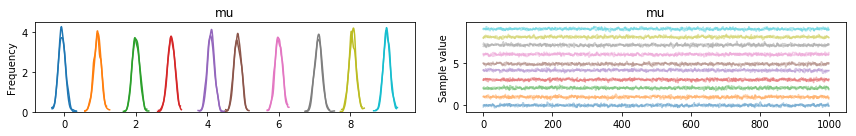

In [5]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 10., shape=ndim)
    obs = pm.Normal('obs', mu, 1., observed=data)
    trace = pm.sample()
    cov = np.atleast_1d(pm.trace_cov(trace))
    step = pm.HamiltonianMC(scaling=np.linalg.inv(cov))
    trace_hmc = pm.sample(1000, tune=1000, step=step, chains=nchain)

pm.traceplot(trace_hmc);

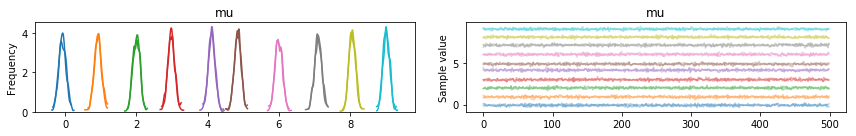

In [6]:
pm.traceplot(trace);

## In Pyro (HMC)

In [7]:
def m2(data):
    data_ = Variable(torch.Tensor(data))
    mu = pyro.sample('mu',
                     dist.Normal(
                         mu=Variable(torch.Tensor(torch.zeros(ndim))),
                         sigma=Variable(torch.Tensor(torch.ones(ndim)*10))
                                )
                     )
    pyro.sample('obs',
                dist.Normal(
                    mu=mu,
                    sigma=Variable(torch.Tensor(torch.ones(ndim)))
                           ),
                obs=data_)

In [8]:
draw = 2000
ntune = 1000
n_steps = max(1, int(step.path_length / step.step_size))
hmc_kernel = HMC(m2, step_size=step.step_size, num_steps=n_steps)
mcmc_run = MCMC(hmc_kernel, num_samples=draw, warmup_steps=ntune)

mtrace = []
for i in range(nchain):
    pyro.get_param_store().clear()
    post_pyro = []
    for j, (t, _) in tqdm(enumerate(mcmc_run._traces(data)), total=draw+1):
        post_trace = t.nodes['mu']['value']
        post_pyro.append(post_trace.data.numpy())
    mtrace.append(np.asarray(post_pyro)[ntune:])

100%|█████████▉| 2000/2001 [00:38<00:00, 40.55it/s]


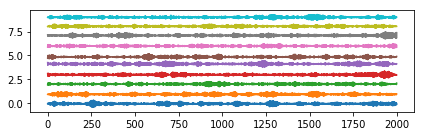

In [9]:
mtrace = np.asarray(mtrace).reshape(nchain*(draw-ntune), ndim, -1).squeeze()
_, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(mtrace);
plt.tight_layout();

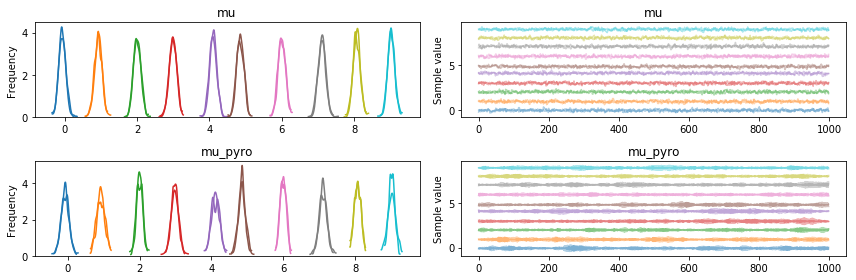

In [10]:
trace_hmc.add_values(dict(mu_pyro=mtrace))
pm.traceplot(trace_hmc);

## In Pyro (NUTS)

In [11]:
step.step_size

0.14058533129758727

In [12]:
draw = 1000
ntune = 500
nuts_kernel = NUTS(m2, step_size=.1)
mcmc_run = MCMC(nuts_kernel, num_samples=draw, warmup_steps=ntune)

mtrace2 = []
for i in range(nchain):
    pyro.get_param_store().clear()
    post_pyro = []
    for j, (t, _) in tqdm(enumerate(mcmc_run._traces(data)), total=draw+1):
        post_trace = t.nodes['mu']['value']
        post_pyro.append(post_trace.data.numpy())
    mtrace2.append(np.asarray(post_pyro)[ntune:])

100%|█████████▉| 1000/1001 [00:09<00:00, 103.94it/s]


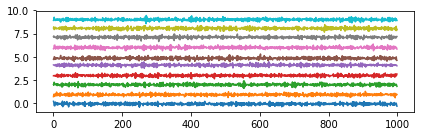

In [13]:
mtrace2 = np.asarray(mtrace2).reshape(nchain*(draw-ntune), ndim, -1).squeeze()
_, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(mtrace2);
plt.tight_layout();

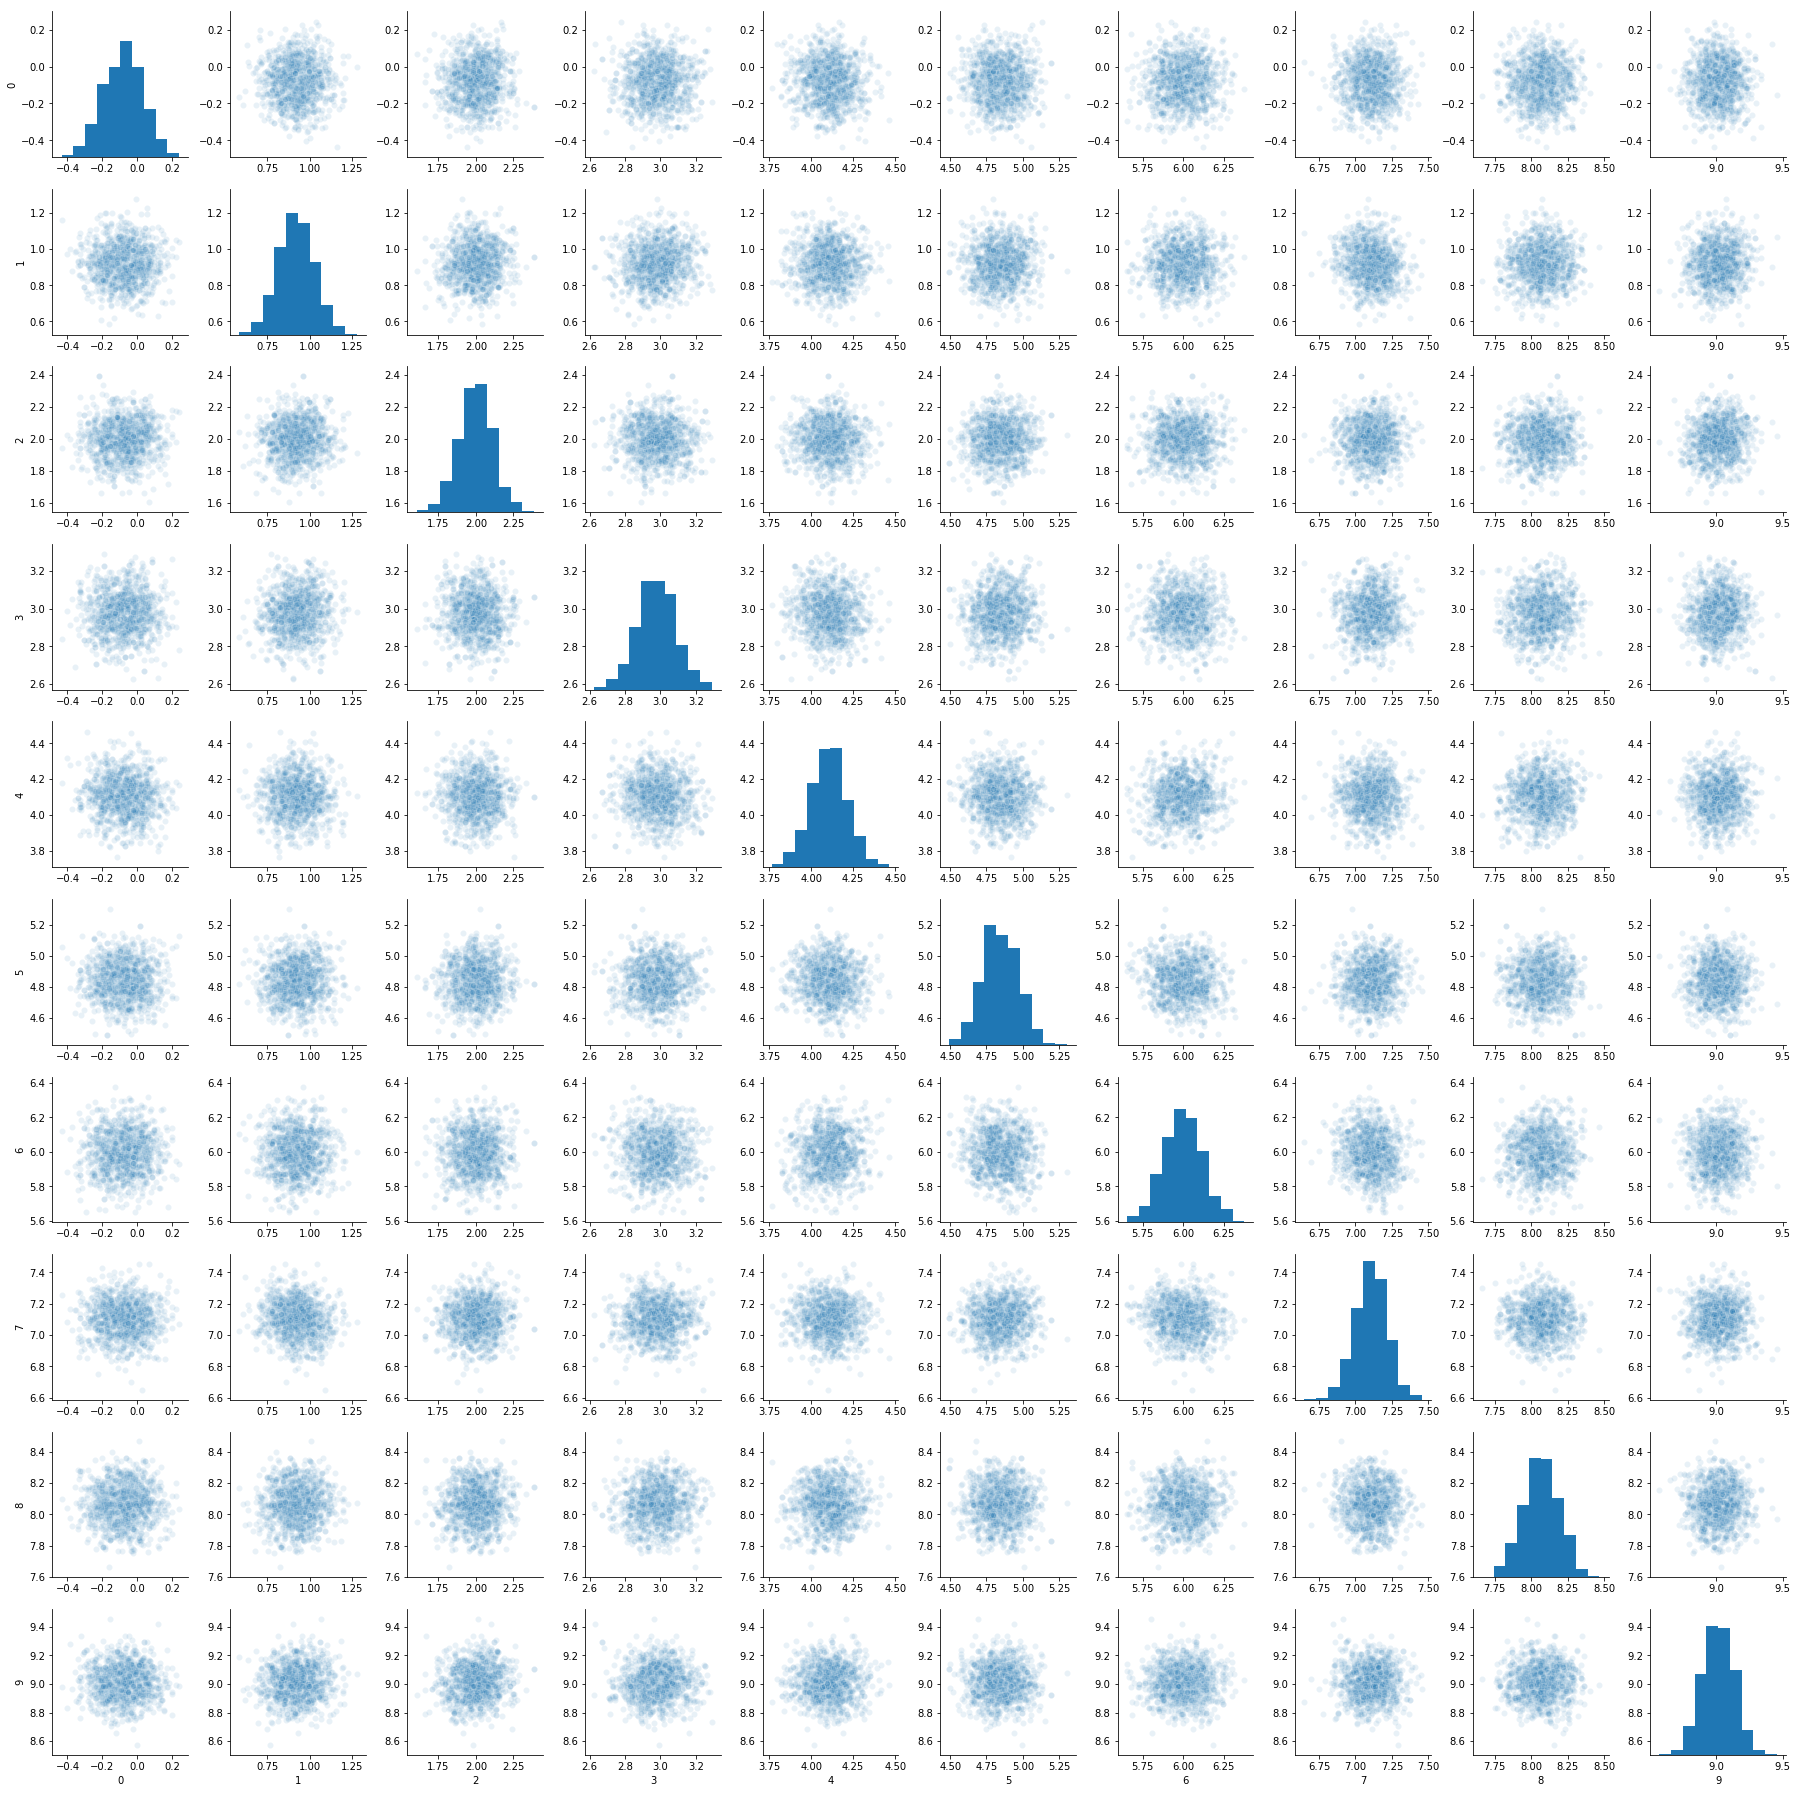

In [14]:
sns.pairplot(pd.DataFrame(mtrace2), plot_kws=dict(alpha=.1));

## Getting logp from pyro

In [15]:
def m2():
    data_ = Variable(torch.Tensor(data))
    mu = pyro.sample('mu',
                     dist.Normal(
                         mu=Variable(torch.Tensor(torch.zeros(ndim))),
                         sigma=Variable(torch.Tensor(torch.ones(ndim)*10))
                                )
                     )
    pyro.sample('obs',
                dist.Normal(
                    mu=mu,
                    sigma=Variable(torch.Tensor(torch.ones(ndim)))
                           ),
                obs=data_)
hmc_kernel = HMC(m2, step_size=step.step_size, num_steps=n_steps)

In [16]:
hmc_kernel.setup()

In [17]:
hmc_kernel.initial_trace()

In [18]:
trace = hmc_kernel._prototype_trace

In [19]:
z = {name: node['value'] for name, node in trace.iter_stochastic_nodes()}
z

{'mu': 
  8.0184
 -6.2212
  0.3076
 -2.1891
 -7.8600
  3.1258
  2.2727
  8.2287
 -3.2698
  3.2405
 [torch.FloatTensor of size (10,)]}

In [21]:
trace.log_prob_sum()


-24945.0605
[torch.FloatTensor of size ()]

In [22]:
z['mu'].numpy()

array([ 8.018362  , -6.2212343 ,  0.30763093, -2.1891031 , -7.860048  ,
        3.1258366 ,  2.2726586 ,  8.228709  , -3.2697577 ,  3.2405038 ],
      dtype=float32)

In [23]:
from scipy import stats as st
st.norm.logpdf(data, loc=z['mu'].numpy(), scale=1.).sum()

-24911.485085570945

In [24]:
st.norm.logpdf(data, loc=mu0, scale=1.).sum()

-1450.9153481590647

In [25]:
print(hmc_kernel._args, hmc_kernel._kwargs,'/t')

() {} /t


In [26]:
trace.nodes

NodeView(('_INPUT', 'mu', 'obs', '_RETURN'))

In [27]:
trace.nodes['mu']['value']


 8.0184
-6.2212
 0.3076
-2.1891
-7.8600
 3.1258
 2.2727
 8.2287
-3.2698
 3.2405
[torch.FloatTensor of size (10,)]

In [29]:
hmc_kernel._get_trace(z).log_prob_sum()


-24945.0605
[torch.FloatTensor of size ()]

In [30]:
z_next = {key: Variable(torch.Tensor(mu0)) for key, val in z.items()}
z_next

{'mu': 
  0
  1
  2
  3
  4
  5
  6
  7
  8
  9
 [torch.FloatTensor of size (10,)]}

In [31]:
hmc_kernel._get_trace(z_next).log_prob_sum()


-1484.5558
[torch.FloatTensor of size ()]

# Chain of Gaussian
adapted from the test case
https://github.com/uber/pyro/blob/7b3a0a833b836c1b7b1e981091b514baec819c40/tests/infer/mcmc/test_hmc.py#L32-L37

Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [mu_4, mu_3, mu_2, mu_1]
100%|██████████| 2000/2000 [00:02<00:00, 841.14it/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


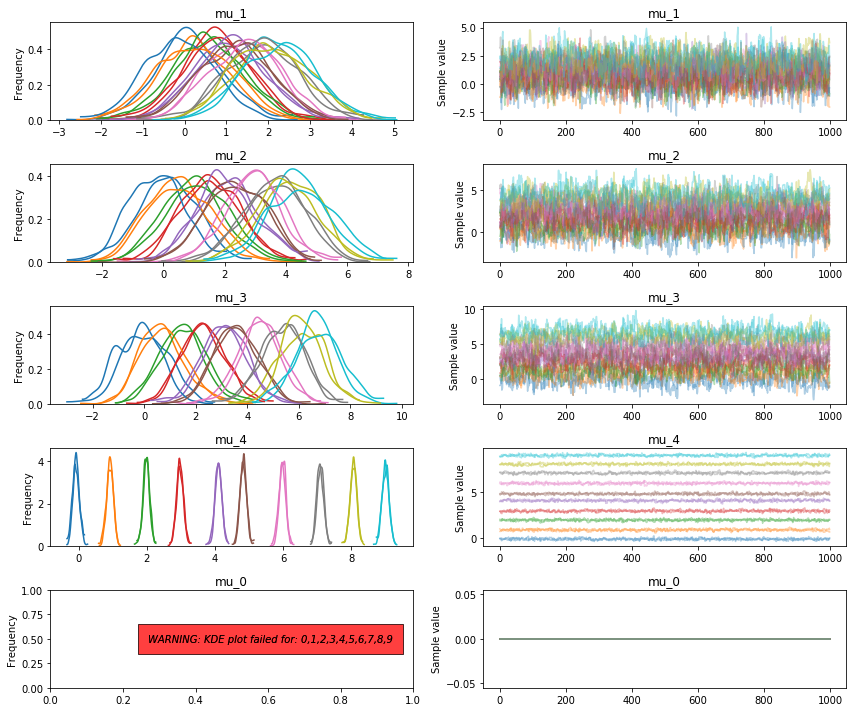

In [34]:
import theano.tensor as tt
import theano

ndim = 10
nlayer = 4
with pm.Model() as chain_gaussian:
    mu = pm.Deterministic('mu_0', tt.zeros(ndim))
    for i in range(nlayer):
        mu = pm.Normal('mu_{}'.format(i+1), mu=mu, sd=1., shape=ndim)
    obs = pm.Normal('obs', mu=mu, sd=1., observed=data)
    
    step = pm.HamiltonianMC(step_scale=.01)
    trace_hmc = pm.sample(1000, tune=1000, step=step, chains=nchain)

pm.traceplot(trace_hmc);

In [35]:
import logging

logging.basicConfig(format='%(levelname)s %(message)s')
logger = logging.getLogger('pyro')
logger.setLevel(logging.INFO)

class GaussianChain(object):

    def __init__(self, dim, chain_len):
        self.dim = dim
        self.chain_len = chain_len
        self.mu_0 = Variable(torch.zeros_like(torch.Tensor(self.dim)), requires_grad=True)
        self.lambda_prec = Variable(torch.ones_like(torch.Tensor(self.dim)))

    def model(self, data):
        mu = pyro.param('mu_0', self.mu_0)
        lambda_prec = self.lambda_prec
        for i in range(1, self.chain_len + 1):
            mu = pyro.sample('mu_{}'.format(i),
                             dist.Normal(mu=mu, sigma=Variable(lambda_prec.data)))
        pyro.sample('obs', dist.Normal(mu, Variable(lambda_prec.data)), obs=data)


fixture = GaussianChain(dim=ndim, chain_len=nlayer)
num_samples=1000
warmup_steps=300
hmc_params={'step_size': 0.165,
            'num_steps': 5}

hmc_kernel = HMC(fixture.model, **hmc_params)
mcmc_run = MCMC(hmc_kernel, num_samples, warmup_steps)
pyro.get_param_store().clear()
post_trace = defaultdict(list)

data_ = Variable(torch.Tensor(data))
for t, _ in mcmc_run._traces(data_):
    for i in range(nlayer + 1):
        param_name = 'mu_' + str(i)
        post_trace[param_name].append(t.nodes[param_name]['value'])

INFO Starting MCMC using kernel - HMC ...
INFO Iteration: 65.
INFO Step size: 0.165000 | Acceptance rate: 0.876923
INFO Iteration: 130.
INFO Step size: 0.165000 | Acceptance rate: 0.707692
INFO Iteration: 195.
INFO Step size: 0.165000 | Acceptance rate: 0.651282
INFO Iteration: 260.
INFO Step size: 0.165000 | Acceptance rate: 0.603846
INFO Iteration: 325.
INFO Step size: 0.165000 | Acceptance rate: 0.587692
INFO Iteration: 390.
INFO Step size: 0.165000 | Acceptance rate: 0.569231
INFO Iteration: 455.
INFO Step size: 0.165000 | Acceptance rate: 0.562637
INFO Iteration: 520.
INFO Step size: 0.165000 | Acceptance rate: 0.565385
INFO Iteration: 585.
INFO Step size: 0.165000 | Acceptance rate: 0.552137
INFO Iteration: 650.
INFO Step size: 0.165000 | Acceptance rate: 0.549231
INFO Iteration: 715.
INFO Step size: 0.165000 | Acceptance rate: 0.546853
INFO Iteration: 780.
INFO Step size: 0.165000 | Acceptance rate: 0.548718
INFO Iteration: 845.
INFO Step size: 0.165000 | Acceptance rate: 0.5502

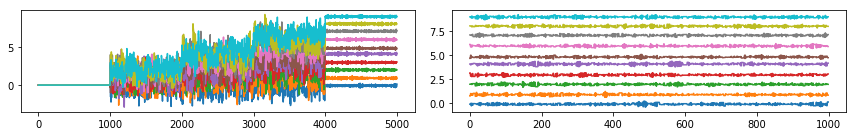

In [36]:
post_pyro = []
for i in range(nlayer + 1):
    param_name = 'mu_' + str(i)
    ichain = torch.stack(post_trace[param_name])
    post_pyro.append(ichain.data.numpy()[:1000, :, np.newaxis])

post_pyro = np.asarray(post_pyro).reshape([(nlayer + 1) * 1000, ndim])

_, ax = plt.subplots(1, 2, figsize=(12, 2))
ax[0].plot(post_pyro.squeeze())
ax[1].plot(post_pyro[4000:, :].squeeze())
plt.tight_layout()

In [37]:
def chain_gaussian2(data):
    data_ = Variable(torch.Tensor(data))
    mu = pyro.param('mu_0', Variable(torch.zeros(ndim), requires_grad=True))
    for i in range(nlayer):
        mu = pyro.sample('mu_{}'.format(i + 1),
                         dist.Normal(mu=mu, sigma=Variable(torch.ones(ndim))))
    pyro.sample(
        'obs', dist.Normal(mu=mu, sigma=Variable(torch.ones(ndim))), obs=data_)


draw = 2000
ntune = 1000
hmc_params = {'step_size': 0.165, 'num_steps': 5}

hmc_kernel = HMC(chain_gaussian2, **hmc_params)
mcmc_run = MCMC(hmc_kernel, draw, ntune)
pyro.get_param_store().clear()
post_trace = defaultdict(list)

for t, _ in mcmc_run._traces(data):
    for i in range(nlayer + 1):
        param_name = 'mu_' + str(i)
        post_trace[param_name].append(t.nodes[param_name]['value'])

INFO Starting MCMC using kernel - HMC ...
INFO Iteration: 150.
INFO Step size: 0.165000 | Acceptance rate: 0.726667
INFO Iteration: 300.
INFO Step size: 0.165000 | Acceptance rate: 0.630000
INFO Iteration: 450.
INFO Step size: 0.165000 | Acceptance rate: 0.591111
INFO Iteration: 600.
INFO Step size: 0.165000 | Acceptance rate: 0.563333
INFO Iteration: 750.
INFO Step size: 0.165000 | Acceptance rate: 0.572000
INFO Iteration: 900.
INFO Step size: 0.165000 | Acceptance rate: 0.562222
INFO Iteration: 1050.
INFO Step size: 0.165000 | Acceptance rate: 0.560952
INFO Iteration: 1200.
INFO Step size: 0.165000 | Acceptance rate: 0.551667
INFO Iteration: 1350.
INFO Step size: 0.165000 | Acceptance rate: 0.547407
INFO Iteration: 1500.
INFO Step size: 0.165000 | Acceptance rate: 0.547333
INFO Iteration: 1650.
INFO Step size: 0.165000 | Acceptance rate: 0.540000
INFO Iteration: 1800.
INFO Step size: 0.165000 | Acceptance rate: 0.538889
INFO Iteration: 1950.
INFO Step size: 0.165000 | Acceptance rate

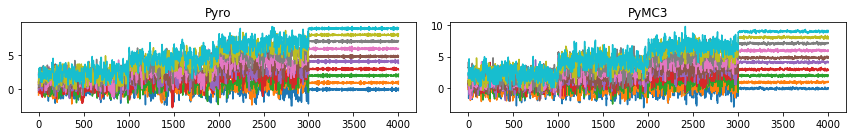

In [38]:
post_pyro = []
post_pymc = []
for i in range(1, nlayer + 1):
    param_name = 'mu_' + str(i)
    ichain = torch.stack(post_trace[param_name])
    post_pyro.append(ichain.data.numpy()[:1000, :, np.newaxis])
    post_pymc.append(trace_hmc[param_name][:1000])

post_pyro = np.asarray(post_pyro).reshape([(nlayer) * 1000, ndim])
post_pymc = np.asarray(post_pymc).reshape([(nlayer) * 1000, ndim])

_, ax = plt.subplots(1, 2, figsize=(12, 2))
ax[0].plot(post_pyro.squeeze())
ax[0].set_title('Pyro')

ax[1].plot(post_pymc.squeeze())
ax[1].set_title('PyMC3')

plt.tight_layout()

In [39]:
draw = 2000
ntune = 1000
nuts_kernel = NUTS(chain_gaussian2, step_size=.1)
mcmc_run = MCMC(nuts_kernel, draw, ntune)
pyro.get_param_store().clear()
post_trace = defaultdict(list)

for t, _ in mcmc_run._traces(data):
    for i in range(nlayer + 1):
        param_name = 'mu_' + str(i)
        post_trace[param_name].append(t.nodes[param_name]['value'])

INFO Starting MCMC using kernel - NUTS ...
INFO Iteration: 150.
INFO Step size: 0.100000 | Acceptance rate: 1.000000
INFO Iteration: 300.
INFO Step size: 0.100000 | Acceptance rate: 1.000000
INFO Iteration: 450.
INFO Step size: 0.100000 | Acceptance rate: 1.000000
INFO Iteration: 600.
INFO Step size: 0.100000 | Acceptance rate: 1.000000
INFO Iteration: 750.
INFO Step size: 0.100000 | Acceptance rate: 1.000000
INFO Iteration: 900.
INFO Step size: 0.100000 | Acceptance rate: 1.000000
INFO Iteration: 1050.
INFO Step size: 0.100000 | Acceptance rate: 1.000000
INFO Iteration: 1200.
INFO Step size: 0.100000 | Acceptance rate: 1.000000
INFO Iteration: 1350.
INFO Step size: 0.100000 | Acceptance rate: 1.000000
INFO Iteration: 1500.
INFO Step size: 0.100000 | Acceptance rate: 1.000000
INFO Iteration: 1650.
INFO Step size: 0.100000 | Acceptance rate: 1.000000
INFO Iteration: 1800.
INFO Step size: 0.100000 | Acceptance rate: 1.000000
INFO Iteration: 1950.
INFO Step size: 0.100000 | Acceptance rat

In [40]:
with chain_gaussian:
    step = pm.NUTS()
    trace_nuts = pm.sample(1000, tune=1000, chains=nchain)

Auto-assigning NUTS sampler...
INFO Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_4, mu_3, mu_2, mu_1]
INFO NUTS: [mu_4, mu_3, mu_2, mu_1]
100%|██████████| 2000/2000 [00:12<00:00, 162.38it/s]


In [41]:
nuts_kernel.step_size

0.1

In [42]:
step.step_size

0.09940884109588133

In [43]:
nuts_kernel.trajectory_length

6.283185307179586

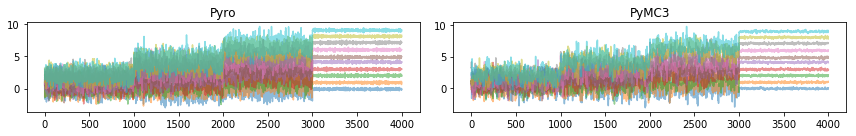

In [44]:
post_pyro = []
post_pymc = []
for i in range(1, nlayer+1):
    param_name = 'mu_' + str(i)
    ichain = torch.stack(post_trace[param_name])
    post_pyro.append(ichain.data.numpy()[:1000,:,np.newaxis])
    post_pymc.append(trace_hmc[param_name][:1000])
    
post_pyro = np.asarray(post_pyro).reshape([(nlayer)*1000, ndim])
post_pymc = np.asarray(post_pymc).reshape([(nlayer)*1000, ndim])

_, ax = plt.subplots(1, 2, figsize=(12, 2))
ax[0].plot(post_pyro.squeeze(), alpha=.5);
ax[0].set_title('Pyro')

ax[1].plot(post_pymc.squeeze(), alpha=.5)
ax[1].set_title('PyMC3')

plt.tight_layout();

# Gaussian with sigma

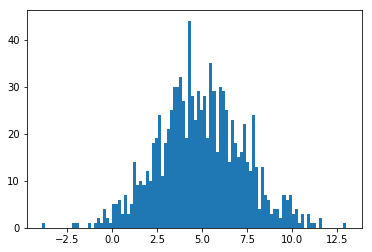

In [45]:
mu0, sigma = 5., 2.4
N = 1000
X = mu0 + np.random.randn(N, 1)*sigma

plt.hist(X, 100);

Multiprocess sampling (2 chains in 2 jobs)
INFO Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, mu]
INFO NUTS: [sd_log__, mu]
100%|██████████| 2000/2000 [00:03<00:00, 586.12it/s]


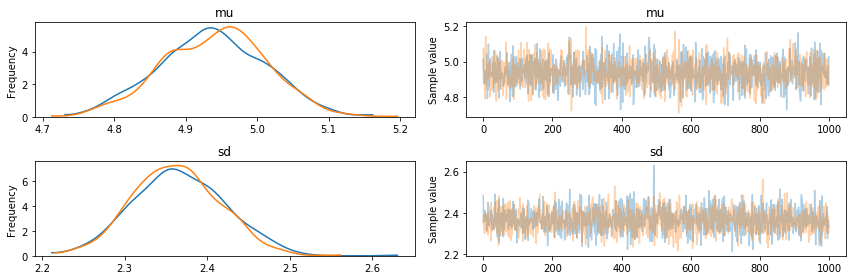

In [46]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 100.)
    sd = pm.Gamma('sd', 1., 1.)
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=X)
    step = pm.NUTS()
    trace_pymc = pm.sample(1000, tune=1000, step=step)

pm.traceplot(trace_pymc);

In [47]:
ndim2 = 1
def m2():
    data_ = Variable(torch.Tensor(X))
    mu = pyro.sample('mu', 
                     dist.Normal(
                     mu=Variable(torch.Tensor(torch.zeros(ndim2))),
                     sigma=Variable(torch.Tensor(torch.ones(ndim2)*100.)))
                    )
    sd = pyro.sample('sd', dist.Gamma(
                     Variable(torch.Tensor(torch.ones(ndim2))),
                     Variable(torch.Tensor(torch.ones(ndim2))))
                    )
    pyro.sample('obs', dist.Normal(mu=mu, sigma=sd),
                obs=data_)

In [48]:
nuts_kernel = NUTS(m2)

In [49]:
nuts_kernel._reset()

In [50]:
nuts_kernel.setup()

In [51]:
trace = nuts_kernel.initial_trace()

In [52]:
trace.nodes['mu']

{'args': (),
 'cond_indep_stack': (),
 'continuation': None,
 'done': True,
 'fn': Normal(),
 'infer': {},
 'is_observed': False,
 'kwargs': {},
 'log_prob_sum': 
 -6.2123
 [torch.FloatTensor of size ()],
 'name': 'mu',
 'scale': 1.0,
 'stop': False,
 'type': 'sample',
 'value': 
 -117.3176
 [torch.FloatTensor of size (1,)]}

In [53]:
zorg = dict(mu=mu0, sd=sigma)
z_next = {key: Variable(torch.Tensor(torch.ones(ndim2)*zorg[key])) for key in zorg.keys()}
z_next

{'mu': 
  5
 [torch.FloatTensor of size (1,)], 'sd': 
  2.4000
 [torch.FloatTensor of size (1,)]}

In [54]:
trace = nuts_kernel._get_trace(z_next)

In [55]:
# from pyro.ops.integrator import velocity_verlet

# z = {name: node['value'] for name, node in trace.iter_stochastic_nodes()}
# r = {name: pyro.sample('r_{}_t={}'.format(name, hmc_kernel._t), hmc_kernel._r_dist[name]) for name in z}
# z_new, r_new = velocity_verlet(z, r, hmc_kernel._potential_energy, hmc_kernel.step_size, hmc_kernel.num_steps)

In [56]:
mcmc_run = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500)
mcmc_run.kernel.setup()
mcmc_run.kernel._prototype_trace.nodes['mu']

{'args': (),
 'cond_indep_stack': (),
 'continuation': None,
 'done': True,
 'fn': Normal(),
 'infer': {},
 'is_observed': False,
 'kwargs': {},
 'log_prob_sum': 
 -5.5723
 [torch.FloatTensor of size ()],
 'name': 'mu',
 'scale': 1.0,
 'stop': False,
 'type': 'sample',
 'value': 
  31.0481
 [torch.FloatTensor of size (1,)]}

In [57]:
mcmc_run.kernel._prototype_trace.nodes['sd']['value']


 0.2236
[torch.FloatTensor of size (1,)]

In [ ]:
def m2(data):
    data_ = Variable(torch.Tensor(data))
    mu = pyro.sample('mu', 
                     dist.Normal(
                     mu=Variable(torch.Tensor(torch.zeros(ndim2))),
                     sigma=Variable(torch.Tensor(torch.ones(ndim2)*100.)))
                    )
    sd = pyro.sample('sd', dist.Gamma(
                     Variable(torch.Tensor(torch.ones(ndim2))),
                     Variable(torch.Tensor(torch.ones(ndim2))))
                    )
    pyro.sample('obs', dist.Normal(mu=mu, sigma=sd),
                obs=data_)

draw = 2000
ntune = 1000
nuts_kernel = NUTS(m2, step_size=.1)
mcmc_run = MCMC(nuts_kernel, draw, ntune)
pyro.get_param_store().clear()
post_trace = defaultdict(list)

for t, _ in mcmc_run._traces(X):
    post_trace['mu'].append(t.nodes['mu']['value'])
    post_trace['sd'].append(t.nodes['sd']['value'])

In [ ]:
mupost_ = torch.stack(post_trace['mu'])
mupost = mupost_.data.numpy()
sdpost_ = torch.stack(post_trace['sd'])
sdpost = sdpost_.data.numpy()

_, axes = plt.subplots(2, 2, figsize=(12, 6))
ax=axes.flatten()
ax[0].plot(mupost)
ax[0].set_ylim([4.7, 5.4])
ax[1].plot(np.asarray(trace_pymc.get_values('mu', combine=False)).T, alpha=.25)
ax[1].set_ylim([4.7, 5.4])
ax[2].plot(sdpost)
ax[2].set_ylim([2.15, 2.56])
ax[3].plot(np.asarray(trace_pymc.get_values('sd', combine=False)).T, alpha=.25)
ax[3].set_ylim([2.15, 2.56])
plt.tight_layout();

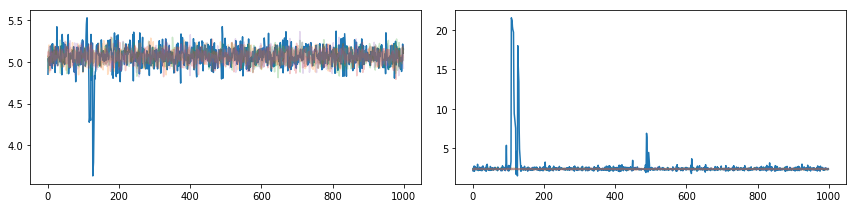

In [56]:
burnin = 1000

_, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot(mupost[burnin:])
ax[0].plot(np.asarray(trace_pymc.get_values('mu', combine=False)).T, alpha=.25)
ax[1].plot(sdpost[burnin:])
ax[1].plot(np.asarray(trace_pymc.get_values('sd', combine=False)).T, alpha=.25)
plt.tight_layout();

# Regression

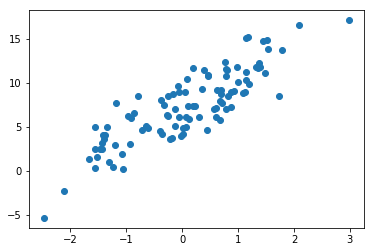

In [57]:
beta = [7., 3.4]
sigma = 2.1
N = 100
X = np.random.randn(N, 1)
Y = beta[0] + beta[1]*X + np.random.randn(N, 1)*sigma

plt.plot(X, Y, 'o');

Multiprocess sampling (4 chains in 4 jobs)
INFO Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_log__, b, mu]
INFO NUTS: [sd_log__, b, mu]
100%|██████████| 2000/2000 [00:01<00:00, 1384.85it/s]


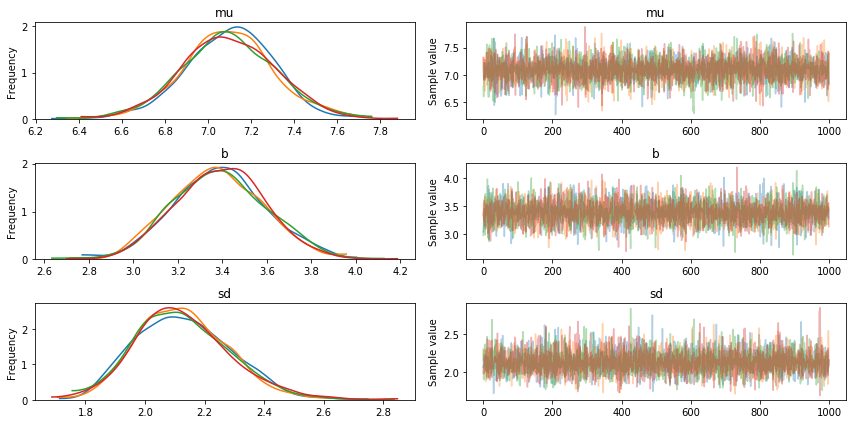

In [59]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 100.)
    b = pm.Normal('b', 0., 10.)
    sd = pm.Gamma('sd', 1., 1.)
    obs = pm.Normal('obs', mu=mu+X*b, sd=sd, observed=Y)
    step = pm.NUTS()
    trace_pymc = pm.sample(1000, tune=1000, step=step)

pm.traceplot(trace_pymc);

In [77]:
def m_regress(X, Y):
    X_, Y_ = Variable(torch.Tensor(X)), Variable(torch.Tensor(Y))
    mu = pyro.sample('mu', 
                     dist.Normal(
                     mu=Variable(torch.Tensor(torch.zeros(1))),
                     sigma=Variable(torch.Tensor(torch.ones(1)*100.)))
                    )
    b = pyro.sample('b', 
                     dist.Normal(
                     mu=Variable(torch.Tensor(torch.zeros(1))),
                     sigma=Variable(torch.Tensor(torch.ones(1)*10.)))
                    )
    sd = pyro.sample('sd', dist.Gamma(
                     Variable(torch.Tensor(torch.ones(1))),
                     Variable(torch.Tensor(torch.ones(1))))
                    )
    yhat = mu + X_ * b
    pyro.sample('obs', dist.Normal(mu=yhat, sigma=sd),
                obs=Y_)

draw = 2000
ntune = 1000
nuts_kernel = NUTS(m_regress, step_size=1.5)

In [85]:
mcmc_run = MCMC(nuts_kernel, draw, ntune)
pyro.get_param_store().clear()
post_trace = defaultdict(list)

for t, _ in mcmc_run._traces(X, Y):
    post_trace['mu'].append(t.nodes['mu']['value'])
    post_trace['b'].append(t.nodes['b']['value'])
    post_trace['sd'].append(t.nodes['sd']['value'])

INFO Starting MCMC using kernel - NUTS ...
INFO Iteration: 150.
INFO Acceptance rate: 1.0
INFO Iteration: 300.
INFO Acceptance rate: 1.0
INFO Iteration: 450.
INFO Acceptance rate: 1.0
INFO Iteration: 600.
INFO Acceptance rate: 1.0
INFO Iteration: 750.
INFO Acceptance rate: 1.0
INFO Iteration: 900.
INFO Acceptance rate: 1.0
INFO Iteration: 1050.
INFO Acceptance rate: 1.0
INFO Iteration: 1200.
INFO Acceptance rate: 1.0
INFO Iteration: 1350.
INFO Acceptance rate: 1.0
INFO Iteration: 1500.
INFO Acceptance rate: 1.0
/usr/local/lib/python3.5/dist-packages/pyro_ppl-0.1.2-py3.5.egg/pyro/poutine/trace.py:17: UserWarning: Encountered NAN log_pdf at site 'sd'
  warnings.warn("Encountered NAN log_pdf at site '{}'".format(name))
/usr/local/lib/python3.5/dist-packages/pyro_ppl-0.1.2-py3.5.egg/pyro/poutine/trace.py:17: UserWarning: Encountered NAN log_pdf at site 'obs'
  warnings.warn("Encountered NAN log_pdf at site '{}'".format(name))
INFO Iteration: 1650.
INFO Acceptance rate: 1.0
INFO Iteration: 

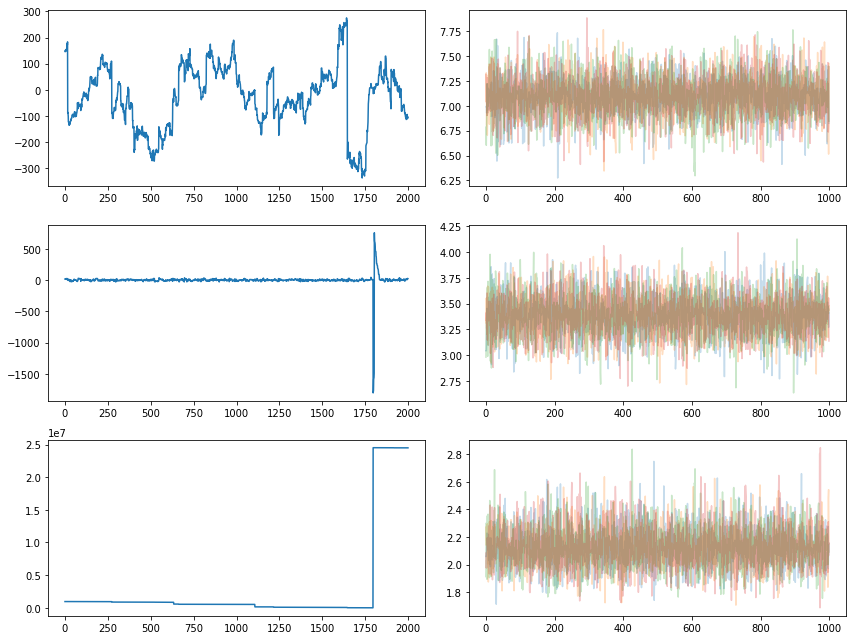

In [86]:
_, axes = plt.subplots(3, 2, figsize=(12, 9))

trace_pyro = defaultdict(list)
for i, varname in enumerate(['mu', 'b', 'sd']):
    post_tmp = torch.stack(post_trace[varname])
    post_ = post_tmp.data.numpy()
    trace_pyro[varname] = post_

    axes[i, 0].plot(post_)
    axes[i, 1].plot(np.asarray(trace_pymc.get_values(varname, combine=False)).T, alpha=.25)

plt.tight_layout();

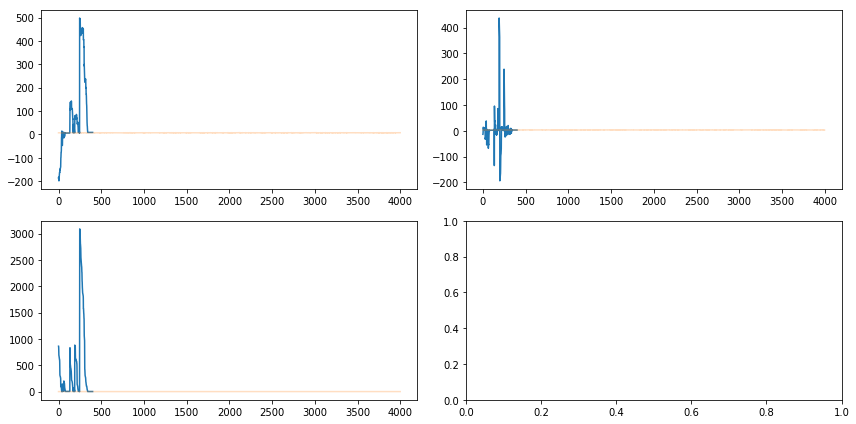

In [82]:
_, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()

burnin=1600
for i, varname in enumerate(['mu', 'b', 'sd']):
    post_tmp = torch.stack(post_trace[varname])
    post_ = post_tmp.data.numpy()
    trace_pyro[varname] = post_

    axes[i].plot(trace_pyro[varname][burnin:])
    axes[i].plot(np.asarray(trace_pymc.get_values(varname, combine=True)).T, alpha=.25)

plt.tight_layout();